In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Messages file

Columns:

	    1.) Time:
				Seconds after midnight with decimal
				precision of at least milliseconds
				and up to nanoseconds depending on
				the requested period
	    2.) Type:
				1: Submission of a new limit order
				2: Cancellation (Partial deletion
				   of a limit order)
				3: Deletion (Total deletion of a limit order)
				4: Execution of a visible limit order
				5: Execution of a hidden limit order
				7: Trading halt indicator 				   
				   (Detailed information below)
	    3.) Order ID:
				Unique order reference number
				(Assigned in order flow)
	    4.) Size:
				Number of shares
	    5.) Price:
				Dollar price times 10000
				(i.e., A stock price of $91.14 is given
				by 911400)
	    6.) Direction:
				-1: Sell limit order
				1: Buy limit order

				Note:
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller)
				initiated trade, i.e. Buy (Sell) trade.


In [ ]:
cols_mess = ["Time", "Type", "Order ID", "Size", "Price", "Direction"]

In [ ]:
pd_message = pd.read_csv("/content/drive/MyDrive/Algo Trading 2024 Big Data/LOBSTER/AAPL_2012-06-21_34200000_57600000_message_10.csv", names = cols_mess, header = None)

In [ ]:
pd_message

,Time,Type,Order ID,Size,Price,Direction
0,34200.004241,1,16113575,18,5853300,1
1,34200.004261,1,16113584,18,5853200,1
2,34200.004447,1,16113594,18,5853100,1
3,34200.025552,1,16120456,18,5859100,-1
4,34200.025580,1,16120480,18,5859200,-1
...,...,...,...,...,...,...
400386,57599.444020,1,287150868,48,5776100,-1
400387,57599.444795,1,287150931,100,5777200,-1
400388,57599.625827,3,286898608,100,5774900,1
400389,57599.913118,4,287150868,48,5776100,-1


In [ ]:
from datetime import datetime, timedelta
def seconds_to_timeofday(seconds):
    # Base datetime object representing midnight
    midnight = datetime(2000, 1, 1)
    # Add the timedelta (in seconds) to midnight
    time_of_day = midnight + timedelta(seconds=seconds)
    return time_of_day.time()  # Return only the time component

# Apply the conversion function to the 'Time' column
pd_message['TimeOfDay'] = pd_message['Time'].apply(seconds_to_timeofday)

In [ ]:
type_mapping = {
    1: 'NewOrder',
    2: 'PartialCancel',
    3: 'TotalDelete',
    4: 'ExecVisible',
    5: 'ExecHidden',
    7: 'TradeHalt'
}

# Replace numeric codes with short names
pd_message['OrderType'] = pd_message['Type'].map(type_mapping)

In [ ]:
def price_to_dollars(price):
  return price / 10000

pd_message["DollarPrice"] = pd_message["Price"].apply(price_to_dollars)

In [ ]:
pd_message

,Time,Type,Order ID,Size,Price,Direction,TimeOfDay,OrderType,DollarPrice
0,34200.004241,1,16113575,18,5853300,1,09:30:00.004241,NewOrder,585.330
1,34200.004261,1,16113584,18,5853200,1,09:30:00.004261,NewOrder,585.320
2,34200.004447,1,16113594,18,5853100,1,09:30:00.004447,NewOrder,585.310
3,34200.025552,1,16120456,18,5859100,-1,09:30:00.025552,NewOrder,585.910
4,34200.025580,1,16120480,18,5859200,-1,09:30:00.025580,NewOrder,585.920
...,...,...,...,...,...,...,...,...,...
400386,57599.444020,1,287150868,48,5776100,-1,15:59:59.444020,NewOrder,577.610
400387,57599.444795,1,287150931,100,5777200,-1,15:59:59.444795,NewOrder,577.720
400388,57599.625827,3,286898608,100,5774900,1,15:59:59.625827,TotalDelete,577.490
400389,57599.913118,4,287150868,48,5776100,-1,15:59:59.913118,ExecVisible,577.610


<Axes: xlabel='TimeOfDay'>

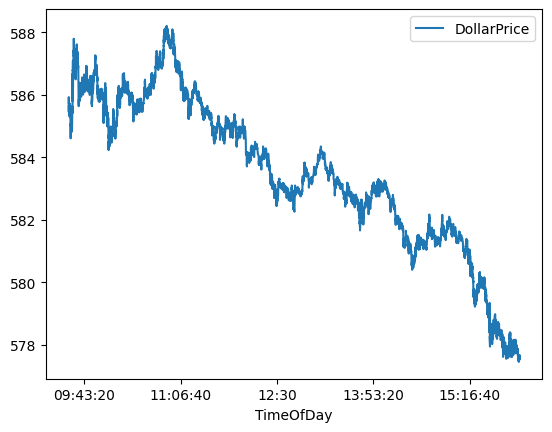

In [ ]:
pd_message[pd_message["OrderType"] == "ExecVisible"].plot(x="TimeOfDay", y = "DollarPrice")

Order Book Construction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class OrderBook:
    def __init__(self):
        # Initialize empty order book
        self.book = {'buy': pd.DataFrame(columns=['price', 'size']),
                     'sell': pd.DataFrame(columns=['price', 'size'])}

    def update(self, message):
        # Update the order book based on a single message
        order_type = message['Type']
        price = message.get('Price', None)  # Price is optional for market orders
        size = message['Size']
        direction = message['Direction']

        if order_type in [1, 4]:  # New order or execution of a limit order
            side = 'buy' if direction == 1 else 'sell'
            self._update_book(side, price, size)
            self._execute_trades()

        elif order_type in [2, 3]:  # Partial cancel or total delete
            side = 'buy' if direction == 1 else 'sell'
            self._update_book(side, price, -size)

        elif order_type == 6:  # Market order with code '6'
            if size > 0:
                side = 'buy' if direction == 1 else 'sell'
                self._execute_market_order(side, size)

        # Handle other types as needed (e.g., trade halt)

    def _execute_market_order(self, side, size):
        # Execute a market order based on price priority
        opposite_side = 'sell' if side == 'buy' else 'buy'  # Match against the opposite side

        while size > 0:
            if self.book[opposite_side].empty:
                print("No matching limit orders available.")
                break

            # Find the best price to match against
            if side == 'buy':
                best_price = self.book[opposite_side]['price'].min()
            else:
                best_price = self.book[opposite_side]['price'].max()

            if pd.isna(best_price):
                print("No best price available.")
                break

            best_size = self.book[opposite_side].loc[self.book[opposite_side]['price'] == best_price, 'size'].iloc[0]
            trade_size = min(size, best_size)

            # Update sizes after trade execution
            self.book[opposite_side].loc[self.book[opposite_side]['price'] == best_price, 'size'] -= trade_size

            # Remove zero or negative size orders
            self.book[opposite_side] = self.book[opposite_side][self.book[opposite_side]['size'] > 0]

            size -= trade_size

            # Remove the price level if fully cleared
            if not self.book[opposite_side].loc[self.book[opposite_side]['price'] == best_price, 'size'].any():
                self.book[opposite_side] = self.book[opposite_side][self.book[opposite_side]['price'] != best_price]

            # Sort the order book after modification
            self.book[opposite_side] = self.book[opposite_side].sort_values(by='price', ascending=(side == 'sell'))

    def _update_book(self, side, price, size):
        # Add or update orders in the book
        if not self.book[side].empty and price in self.book[side]['price'].values:
            self.book[side].loc[self.book[side]['price'] == price, 'size'] += size
        elif size > 0:
            new_order = pd.DataFrame({'price': [price], 'size': [size]})
            self.book[side] = pd.concat([self.book[side], new_order], ignore_index=True)

        # Remove zero or negative size orders
        self.book[side] = self.book[side][self.book[side]['size'] > 0]

        # Aggregate orders at the same price level
        self.book[side] = self.book[side].groupby('price').sum().reset_index()

    def _execute_trades(self):
        # Execute trades where possible
        while True:
            if self.book['buy'].empty or self.book['sell'].empty:
                break

            best_buy_price = self.book['buy']['price'].max()
            best_sell_price = self.book['sell']['price'].min()

            # Check if there's an overlap in prices
            if best_buy_price >= best_sell_price:
                buy_size = self.book['buy'].loc[self.book['buy']['price'] == best_buy_price, 'size'].iloc[0]
                sell_size = self.book['sell'].loc[self.book['sell']['price'] == best_sell_price, 'size'].iloc[0]
                trade_size = min(buy_size, sell_size)

                # Update sizes after trade execution
                self.book['buy'].loc[self.book['buy']['price'] == best_buy_price, 'size'] -= trade_size
                self.book['sell'].loc[self.book['sell']['price'] == best_sell_price, 'size'] -= trade_size

                # Remove zero or negative size orders
                self.book['buy'] = self.book['buy'][self.book['buy']['size'] > 0]
                self.book['sell'] = self.book['sell'][self.book['sell']['size'] > 0]
            else:
                break

    def plot(self, num_levels=None):
        # Plot the current state of the order book
        fig, ax = plt.subplots()

        # Calculate the tick size (ensure it's not zero or too small)
        all_prices = pd.concat([self.book['buy']['price'], self.book['sell']['price']])
        tick_size = all_prices.diff().abs().min()
        if tick_size <= 0:
            tick_size = 100  # Set a default tick size if it's too small or zero

        # Apply num_levels if specified
        if num_levels is not None:
            buy_data = self.book['buy'].nlargest(num_levels, 'price')
            sell_data = self.book['sell'].nsmallest(num_levels, 'price')
        else:
            buy_data = self.book['buy']
            sell_data = self.book['sell']

        # Create continuous price ranges for plotting
        min_price = min(buy_data['price'].min(), sell_data['price'].min())
        max_price = max(buy_data['price'].max(), sell_data['price'].max())
        price_range = np.arange(min_price, max_price + tick_size, tick_size)

        # Create plotting DataFrames with zero sizes for missing prices
        plot_buy_data = pd.DataFrame({'price': price_range})
        plot_sell_data = pd.DataFrame({'price': price_range})

        plot_buy_data = plot_buy_data.merge(buy_data, on='price', how='left').fillna(0)
        plot_sell_data = plot_sell_data.merge(sell_data, on='price', how='left').fillna(0)

        plot_buy_data["price"] = plot_buy_data["price"] / 10000
        plot_sell_data["price"] = plot_sell_data["price"] / 10000
        tick_size /=10000

        # Plot the buy and sell orders
        ax.bar(plot_buy_data['price'], plot_buy_data['size'], width=tick_size, align='center', color='green', label='Buy Orders')
        ax.bar(plot_sell_data['price'], plot_sell_data['size'], width=tick_size, align='center', color='red', label='Sell Orders')

        ax.set_ylabel('Size')
        ax.set_xlabel('Price ($)')
        ax.set_title('Order Book - Top {} Levels'.format(num_levels if num_levels is not None else 'All'))
        ax.legend()

        plt.show()


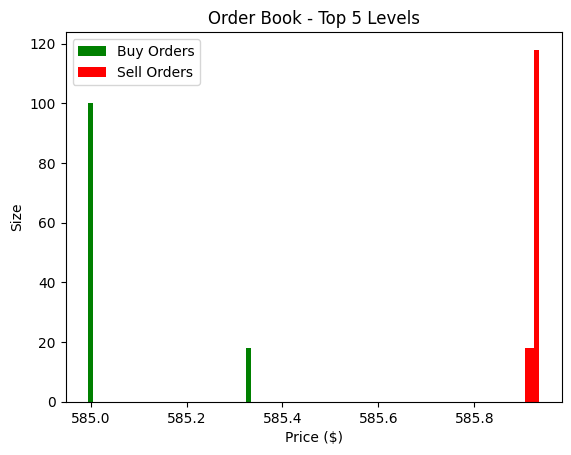

In [ ]:
# Initialization
order_book = OrderBook()

# Assuming 'messages' is a DataFrame containing the first N messages
for index, message in pd_message[:10].iterrows():
    order_book.update(message)

# To plot the current state of the order book
order_book.plot(5)

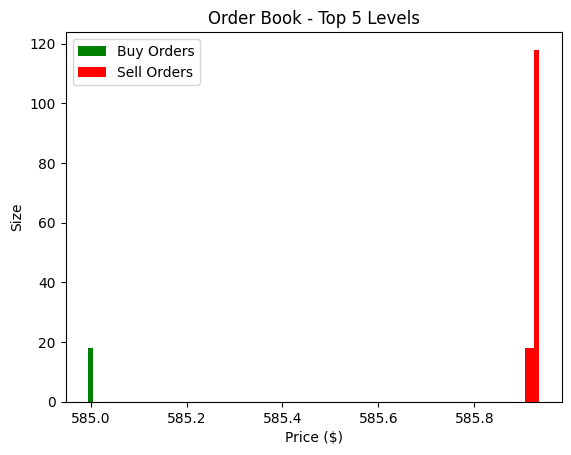

In [ ]:
# Define a market order message
market_order_message = {
    'Time': 34200.201743	,  # Replace with the actual time in seconds after midnight
    'Type': 6,           # Use code '6' to indicate a market order
    'Order ID': 12345,   # Unique order reference number
    'Size': 100,         # Number of shares
    'Direction': -1       # 1 for a buy market order, -1 for a sell market order
}

# Send the market order to the OrderBook
order_book.update(market_order_message)
order_book.plot(5)

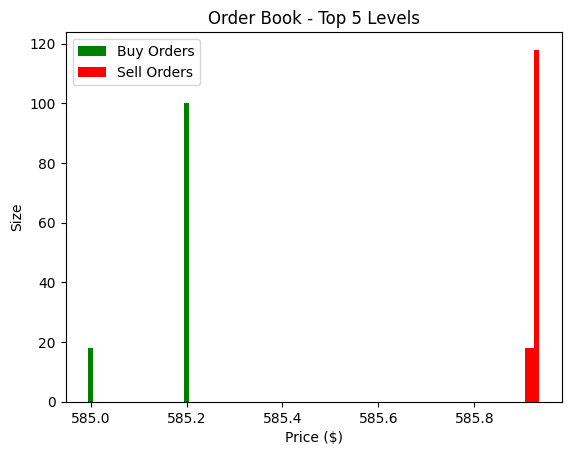

In [ ]:
# Define a limit order message
limit_order_message = {
    'Time': 34201.201743	,  # Replace with the actual time in seconds after midnight
    'Type': 1,           # Use code '1' to indicate a new limit order
    'Order ID': 12346,   # Unique order reference number
    'Size': 100,         # Number of shares
    'Price' : 585.2 * 10000,
    'Direction': 1       # 1 for a buy order, -1 for a sell order
}

# Send the market order to the OrderBook
order_book.update(limit_order_message)
order_book.plot(5)

In [ ]:
order_book.book

{'buy':        price  size
 0  5850000.0   100,
 'sell':        price  size
 0  5852000.0     8
 1  5859200.0    18
 2  5859300.0   118}

Orderbook File:

Columns:

 	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
	    ...

	Notes:
	------

		- Levels:

		The term level refers to occupied price levels. This implies
		that the difference between two levels in the LOBSTER output
		is not necessarily the minimum ticks size.

		- Unoccupied Price Levels:

		When the selected number of levels exceeds the number of levels
		available the empty order book positions are filled with dummy
		information to guarantee a symmetric output. The extra bid
		and/or ask prices are set to -9999999999 and 9999999999,
		respectively. The Corresponding volumes are set to 0.

		- Trading Halts:

		When trading halts, a message of type '7' is written into the
		'message' file. The corresponding price and trade direction
		are set to '-1' and all other properties are set to '0'.
		Should the resume of quoting be indicated by an additional
		message in NASDAQ's Historical TotalView-ITCH files, another
		message of type '7' with price '0' is added to the 'message'
		file. Again, the trade direction is set to '-1' and all other
		fields are set to '0'.
		When trading resumes a message of type '7' and
		price '1' (Trade direction '-1' and all other
		entries '0') is written to the 'message' file. For messages
		of type '7', the corresponding order book rows contain a
		duplication of the preceding order book state. The reason
		for the trading halt is not included in the output.

			Example: Stylized trading halt messages in 'message' file.

			Halt: 				36023	| 7 | 0 | 0 | -1 | -1
											...
			Quoting: 			36323 	| 7 | 0 | 0 | 0  | -1
											...
			Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
											...

			The vertical bars indicate the different columns in the  
			message file.

In [ ]:
lob_path = "/content/drive/MyDrive/Algo Trading 2024 Big Data/LOBSTER/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv"

In [ ]:
def read_orderbook(file_path, num_levels):
    column_names = []
    for i in range(1, num_levels + 1):
        column_names.extend([f'Ask Price {i}', f'Ask Size {i}', f'Bid Price {i}', f'Bid Size {i}'])

    orderbook = pd.read_csv(file_path, names=column_names)

    # Transform prices
    for i in range(1, num_levels + 1):
        orderbook[f'Ask Price {i}'] /= 10000
        orderbook[f'Bid Price {i}'] /= 10000

    return orderbook

In [ ]:
pd_lob = read_orderbook(lob_path, 10)

In [ ]:
pd_lob

,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,...,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9,Ask Price 10,Ask Size 10,Bid Price 10,Bid Size 10
0,585.94,200,585.33,18,585.98,200,585.30,150,586.10,200,...,584.53,300,587.65,1160,584.38,200,587.90,500,584.27,300
1,585.94,200,585.33,18,585.98,200,585.32,18,586.10,200,...,584.65,300,587.65,1160,584.53,300,587.90,500,584.38,200
2,585.94,200,585.33,18,585.98,200,585.32,18,586.10,200,...,584.93,300,587.65,1160,584.65,300,587.90,500,584.53,300
3,585.91,18,585.33,18,585.94,200,585.32,18,585.98,200,...,584.93,300,587.39,100,584.65,300,587.65,1160,584.53,300
4,585.91,18,585.33,18,585.92,18,585.32,18,585.94,200,...,584.93,300,587.10,10,584.65,300,587.39,100,584.53,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400386,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.76,100,577.45,200,577.77,100,577.43,100
400387,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.75,600,577.45,200,577.76,100,577.43,100
400388,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.75,600,577.45,200,577.76,100,577.43,100
400389,577.67,300,577.54,410,577.68,200,577.53,1400,577.69,160,...,577.46,100,577.76,100,577.45,200,577.78,200,577.43,100


In [ ]:
def plot_orderbook_snapshot(orderbook, row_index, num_levels):
    snapshot = orderbook.iloc[row_index]
    ask_prices = [snapshot[f'Ask Price {i}'] for i in range(1, num_levels + 1)]
    bid_prices = [snapshot[f'Bid Price {i}'] for i in range(1, num_levels + 1)]
    ask_sizes = [snapshot[f'Ask Size {i}'] for i in range(1, num_levels + 1)]
    bid_sizes = [snapshot[f'Bid Size {i}'] for i in range(1, num_levels + 1)]

    plt.figure(figsize=(10, 6))
    plt.bar(ask_prices, ask_sizes, color='red', width=0.01, label='Ask Orders')
    plt.bar(bid_prices, bid_sizes, color='green', width=0.01, label='Bid Orders')
    plt.xlabel('Price ($)')
    plt.ylabel('Size')
    plt.title(f'Order Book Snapshot at Index {row_index}')
    plt.legend()
    plt.show()

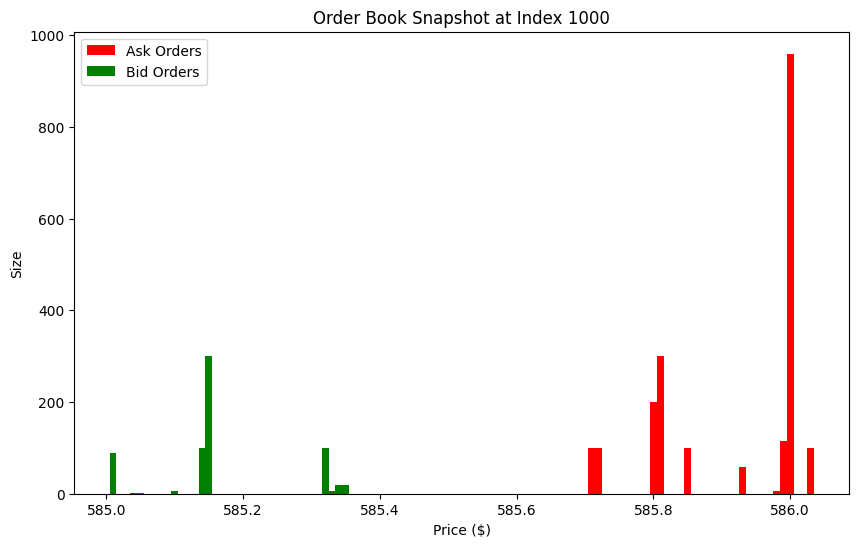

In [ ]:
plot_orderbook_snapshot(pd_lob, 1000, 10)

In [ ]:
pd_lob

,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,...,Bid Price 8,Bid Size 8,Ask Price 9,Ask Size 9,Bid Price 9,Bid Size 9,Ask Price 10,Ask Size 10,Bid Price 10,Bid Size 10
0,585.94,200,585.33,18,585.98,200,585.30,150,586.10,200,...,584.53,300,587.65,1160,584.38,200,587.90,500,584.27,300
1,585.94,200,585.33,18,585.98,200,585.32,18,586.10,200,...,584.65,300,587.65,1160,584.53,300,587.90,500,584.38,200
2,585.94,200,585.33,18,585.98,200,585.32,18,586.10,200,...,584.93,300,587.65,1160,584.65,300,587.90,500,584.53,300
3,585.91,18,585.33,18,585.94,200,585.32,18,585.98,200,...,584.93,300,587.39,100,584.65,300,587.65,1160,584.53,300
4,585.91,18,585.33,18,585.92,18,585.32,18,585.94,200,...,584.93,300,587.10,10,584.65,300,587.39,100,584.53,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400386,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.76,100,577.45,200,577.77,100,577.43,100
400387,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.75,600,577.45,200,577.76,100,577.43,100
400388,577.61,48,577.54,410,577.67,300,577.53,1400,577.68,200,...,577.46,100,577.75,600,577.45,200,577.76,100,577.43,100
400389,577.67,300,577.54,410,577.68,200,577.53,1400,577.69,160,...,577.46,100,577.76,100,577.45,200,577.78,200,577.43,100


In [ ]:
def plot_bid_ask_time_series(orderbook, num_levels, start_time=None, end_time=None):
    # Filter the DataFrame for the specified time range if provided
    if start_time is not None and end_time is not None:
        orderbook = orderbook.loc[start_time:end_time]

    plt.figure(figsize=(15, 8))

    # Plotting bid and ask prices for each level
    for i in range(1, num_levels + 1):
        plt.plot(orderbook.index, orderbook[f'Ask Price {i}'], label=f'Ask Price Level {i}', color=f'C{i}')
        plt.plot(orderbook.index, orderbook[f'Bid Price {i}'], label=f'Bid Price Level {i}', color=f'C{i}', linestyle='dashed')

    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.title(f'Time Series of Bid and Ask Prices for the First {num_levels} Levels')
    plt.legend()
    plt.show()

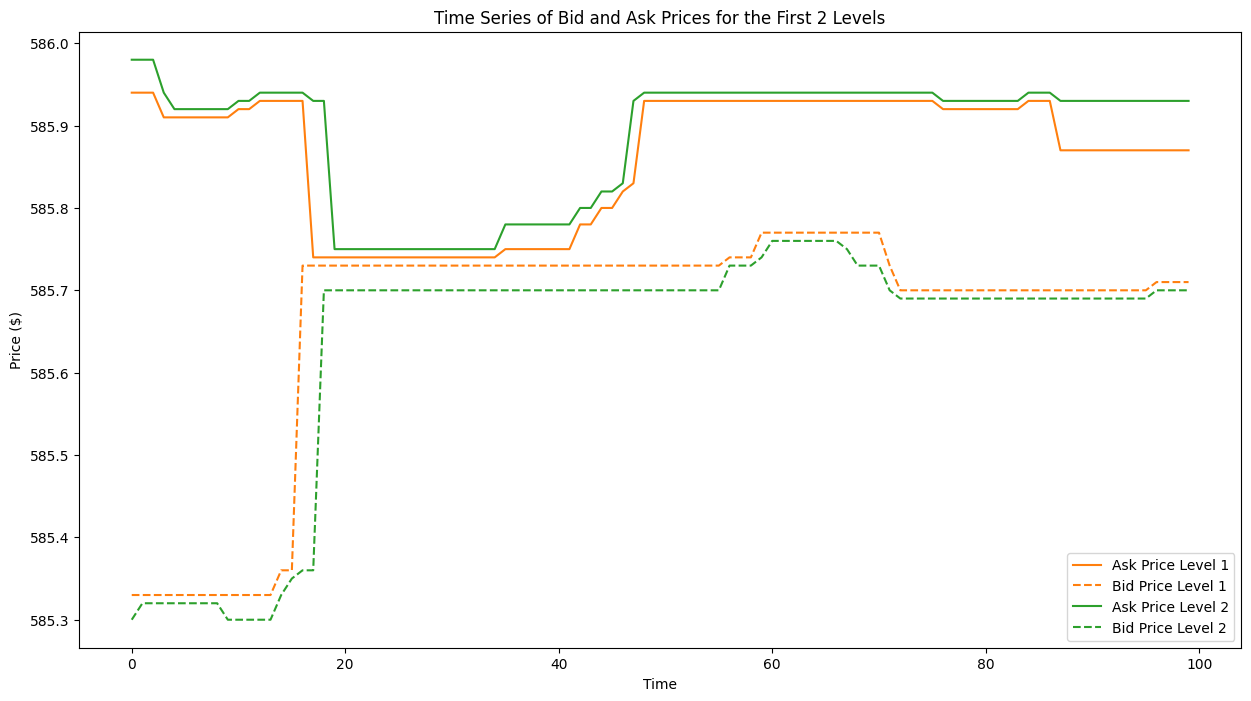

In [ ]:
plot_bid_ask_time_series(pd_lob[:100], num_levels = 2)